In [ ]:
# goal of this analysis is to get an idea of whether SST cells are being driven by the VIP-halo stim.
# In particular, what is the differential degree of drive?

In [1]:
import pyute as ut
import matplotlib.pyplot as plt
import h5py
import skimage.segmentation as sks
import skimage.morphology as skm
import numpy as np
import pdb
import os
import size_contrast_analysis as sca
import sklearn
import sklearn.linear_model as sklm
from importlib import reload
import size_contrast_opto_analysis as scoa
import scipy.interpolate as sip
import scipy.stats as sst
import naka_rushton_analysis as nra
import scipy.spatial.distance as ssd
import sim_utils
reload(ut)
%matplotlib notebook

/Users/dan/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


### Ignore these first commented out cells-- they are just how I generated the decoding weights, etc., from the event traces

In [2]:
# dsfile = '../shared_data/pyr_l23_data_struct.hdf5'

In [3]:
# nbefore = 8
# nafter = 8

In [4]:
# import pandas as pd
# def select_trials(trial_info,selector,training_frac,include_all=False):
#     # dict saying what to do with each trial type. If a function, apply that function to the trial info column to
#     # obtain a boolean indexing variable
#     # if 0, then the tuning output should be indexed by that variable
#     # if 1, then that variable will be marginalized over in the tuning output
#     def gen_train_test_exptwise(ti):
#         ntrials = ti[params[0]].size
#         gd = np.ones((ntrials,),dtype='bool')
#         for param in params:
#             if callable(selector[param]): # all the values of selector that are functions, ignore trials where that function evaluates to False
#                 exclude = ~selector[param](ti[param])
#                 gd[exclude] = False
#         condition_list = gen_condition_list(ti,selector) # automatically, separated out such that each half of the data gets an equivalent fraction of trials with each condition type
#         condition_list = [c[gd] for c in condition_list]
#         in_training_set = np.zeros((ntrials,),dtype='bool')
#         in_test_set = np.zeros((ntrials,),dtype='bool')
#         to_keep = output_training_test(condition_list,training_frac)
#         in_training_set[gd] = to_keep
#         in_test_set[gd] = ~to_keep
#         if include_all:
#             train_test = [in_training_set,in_test_set,np.logical_or(in_training_set,in_test_set)]
#         else:
#             train_test = [in_training_set,in_test_set]
#         return train_test,ntrials

#     params = list(selector.keys())
#     keylist = list(trial_info.keys())
#     if isinstance(trial_info[keylist[0]],dict):
#         ntrials = {}
#         train_test = {}
#         for key in trial_info.keys():
#             ti = trial_info[key]
#             train_test[key],ntrials[key] = gen_train_test_exptwise(ti)
#     else:
#         ti = trial_info
#         train_test,ntrials = gen_train_test_exptwise(ti)

#     return train_test

# def gen_condition_list(ti,selector,filter_selector=lambda x:True):
# # ti: trial_info generated by ut.compute_tavg_dataframe
# # selector: dict where each key is a param in ti.keys(), and each value is either a callable returning a boolean,
# # to be applied to ti[param], or an input to the function filter_selector
# # filter selector: if filter_selector(selector[param]), the tuning curve will be separated into the unique elements of ti[param].
#     params = list(selector.keys())
#     condition_list = []
#     for param in params:
#         if not callable(selector[param]) and filter_selector(selector[param]):
#             condition_list.append(ti[param])
#     return condition_list

# def output_training_test(condition_list,training_frac):
#     # output training and test sets balanced for conditions
#     # condition list, generated by gen_condition_list, has a row for each condition that should be equally assorted
#     if not isinstance(condition_list,list):
#         condition_list = [condition_list.copy()]
#     iconds,uconds = zip(*[pd.factorize(c,sort=True) for c in condition_list])
#     #uconds = [np.sort(u) for u in uconds]
#     nconds = np.array([u.size for u in uconds])
#     in_training_set = np.zeros(condition_list[0].shape,dtype='bool')
#     for iflat in range(np.prod(nconds)):
#         coords = np.unravel_index(iflat,tuple(nconds))
#         lkat = np.where(ut.k_and(*[iconds[ic] == coords[ic] for ic in range(len(condition_list))]))[0]
#         n_train = int(np.round(training_frac*len(lkat)))
#         to_train = np.random.choice(lkat,n_train,replace=False)
#         in_training_set[to_train] = True
#     #assert(True==False)
#     return in_training_set

In [5]:
# df,roi_info,trial_info = ut.compute_tavg_dataframe(dsfile,expttype='size_contrast_0')


In [6]:
# tuning,uparam,displacement,pval = sim_utils.compute_tuning(dsfile,datafield='decon',running=False,expttype='size_contrast_0')

In [7]:
# def gen_sc_selector():
#     selector = {}
#     selector['running'] = lambda x: np.logical_not(x)
#     selector['stimulus_size_deg'] = 0
#     selector['stimulus_contrast'] = 0
#     selector['stimulus_direction_deg'] = 1
#     return selector
# selector = gen_sc_selector()


In [8]:
# reload(ut)
# nreps = 5
# train_test = [None for irep in range(nreps)]
# for irep in range(nreps):
#     train_test[irep] = ut.select_trials(trial_info,selector,0.5,seed=irep)

In [9]:
# keylist = list(train_test[0].keys())

In [10]:
# reload(sca)
# equate_ori = True
# auroc,reg,proc,top_score = [[None for irep in range(nreps)] for _ in range(4)]
# for irep in range(nreps):
#     print(irep)
#     # compute encoding axes based on training set trials
#     reg[irep],proc[irep],top_score[irep] = sca.compute_encoding_axes(dsfile,expttype='size_contrast_0',training_set=train_test[irep],running_trials=False,equate_ori=equate_ori)
#     reg_same = reg[irep].copy()
#     for r in reg_same:
#         if not r is None:
#             for rr in r:
#                 if not rr is None:
#                     rr[1] = rr[0].copy()
#     # compute auroc based on test set trials: take population activity vectors for 0 and target contrast, use regression
#     # trained on training set to predict contrast for both sets of population activity vectors, compute AUROC of predicted contrasts for both
#     auroc[irep] = sca.compute_encoding_axis_auroc(reg_same,proc[irep])

In [11]:
# for irep in range(nreps):
#     for iexpt in range(len(proc[irep])):
#         proc[irep][iexpt]['uangle'] = proc[irep][iexpt]['uangle'][:4]

In [35]:
# tuning_tavg = [np.nanmean(t[:,:,:,:,8:-8],4) if not t is None else None for t in tuning]

In [12]:
# keys = ['proc','auroc','reg','top_score','tuning_tavg']
# values = [proc,auroc,reg,top_score,tuning_tavg]
# processed_dicti = {k:v for k,v in zip(keys,values)}
# np.save('contrast_decoding_variables.npy',processed_dicti,allow_pickle=True)

## Here are the only two files you need to load-- assumes they are in the same folder as the notebook

In [32]:
processed_dicti = np.load('contrast_decoding_variables.npy',allow_pickle=True)[()]
keys = ['proc','auroc','reg','top_score','tuning_tavg']
proc,auroc,reg,top_score,tuning_tavg = [processed_dicti[key] for key in keys]

In [17]:
npyfile = np.load('size_contrast_behavior_summary.npy',allow_pickle=True)[()]
lick_rate,size,contrast,animal_id = [npyfile[key] for key in ['lick_rate','size','contrast','animal_id']]

In [15]:
nreps = len(reg)

In [16]:
reload(sca)
projections = [None for irep in range(nreps)]
for irep in range(nreps):
    projections[irep] = sca.compute_encoding_axis_projections(reg[irep],proc[irep])

In [18]:
fa = np.nanmean(lick_rate[contrast==0])
reload(sca)
# auroc[irep] = sca.compute_encoding_axis_auroc(reg_same,proc)
hit = [None for irep in range(nreps)]
for irep in range(nreps):
    hit[irep] = sca.compute_encoding_axis_hit_from_fa(reg[irep],proc[irep],fa=fa)

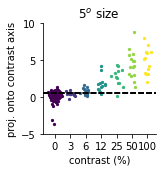

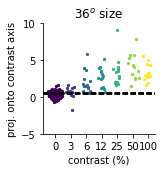

In [19]:
irep = 0
iexpt = 0
isize = 0
iangle = 0
ncontrast = len(proc[irep][iexpt]['ucontrast'])
usize = proc[irep][iexpt]['usize']
colors = plt.cm.viridis(np.linspace(0,1,ncontrast))
for isize in [0,4]:
    plt.figure(figsize=(2.5,2.5))
    for irep in range(1):
        for iangle in range(4):
            for icontrast in range(ncontrast):
                to_plot = projections[irep][(iexpt,isize,icontrast,iangle)]
                plt.scatter(icontrast*np.ones_like(to_plot)+0.15*np.random.randn(*(to_plot.shape)),to_plot,s=5,c=colors[icontrast:icontrast+1])#,edgecolor='k'
            plt.axhline(np.nanpercentile(projections[irep][(iexpt,isize,0,iangle)],100-100*fa),c='k',linestyle='dashed')
    ut.erase_top_right()
    plt.xticks(np.arange(ncontrast),(100*proc[irep][iexpt]['ucontrast']).astype('int'))
    plt.xlabel('contrast (%)')
    plt.ylabel('proj. onto contrast axis')
    plt.title('%d$^o$ size '%usize[isize])
    plt.ylim((-5,10))
    plt.tight_layout()
#     plt.savefig('figures/distribution_vs_contrast_at_size_%d_example_mouse.eps'%isize)

In [21]:
irep = 0
iexpt = 0
icutoff = 0
isize = 0
iangle = 0

In [22]:
contrast_axis,contrast_axis_svd = [[[None for _ in p] for p in proc] for _ in range(2)]
for irep in range(nreps):
    for iexpt in range(len(proc[irep])):
        if not reg[irep][iexpt][icutoff] is None:
            contrast_axis[irep][iexpt],contrast_axis_svd[irep][iexpt] = [[None for _ in reg[irep][iexpt][icutoff]] for _ in range(2)]
            for isize in range(len(reg[irep][iexpt][icutoff])):
                contrast_axis[irep][iexpt][isize],contrast_axis_svd[irep][iexpt][isize] = [[None for _ in reg[irep][iexpt][icutoff][isize]] for _ in range(2)]
                for iangle in range(len(reg[irep][iexpt][icutoff][isize])):
                    contrast_axis[irep][iexpt][isize][iangle] = proc[irep][iexpt]['u'][:,:proc[irep][iexpt]['cutoffs'][icutoff]] @ reg[irep][iexpt][icutoff][isize][iangle].coef_
                    contrast_axis_svd[irep][iexpt][isize][iangle] = reg[irep][iexpt][icutoff][isize][iangle].coef_
                contrast_axis[irep][iexpt][isize] = np.concatenate([c[np.newaxis] for c in contrast_axis[irep][iexpt][isize]])
                contrast_axis_svd[irep][iexpt][isize] = np.concatenate([c[np.newaxis] for c in contrast_axis_svd[irep][iexpt][isize]])
            contrast_axis[irep][iexpt] = np.concatenate([c[np.newaxis] for c in contrast_axis[irep][iexpt]])
            contrast_axis_svd[irep][iexpt] = np.concatenate([c[np.newaxis] for c in contrast_axis_svd[irep][iexpt]])

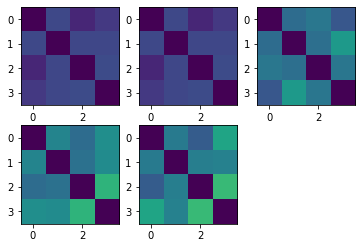

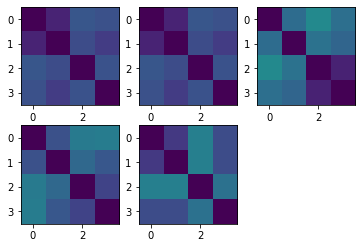

In [23]:
for iexpt in range(len(contrast_axis)):
    if not contrast_axis[irep][iexpt] is None:
        plt.figure()
        for isize in range(contrast_axis_svd[irep][iexpt].shape[0]):
            plt.subplot(2,3,isize+1)
            plt.imshow(ssd.squareform(ssd.pdist(contrast_axis_svd[irep][iexpt][isize],metric='cosine')),vmin=0,vmax=2)

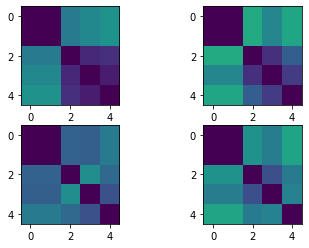

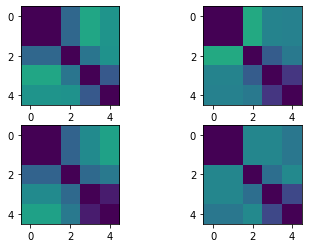

In [24]:
for iexpt in range(len(contrast_axis_svd)):
    if not contrast_axis_svd[irep][iexpt] is None:
        plt.figure()
        for iangle in range(contrast_axis_svd[irep][iexpt].shape[1]):
            plt.subplot(2,2,iangle+1)
            plt.imshow(ssd.squareform(ssd.pdist(contrast_axis_svd[irep][iexpt][:,iangle],metric='cosine')),vmin=0,vmax=2)

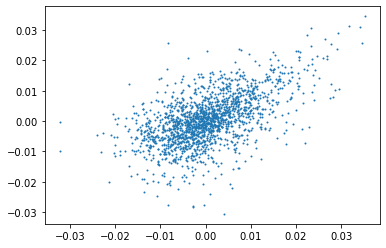

In [25]:
plt.figure()
iexpt = 0
isize = 0
iangle1,iangle2 = 0,1
plt.scatter(contrast_axis[irep][iexpt][isize,iangle1],contrast_axis[irep][iexpt][isize,iangle2],s=1)

0
1
5
got here
7
8
10
11
12


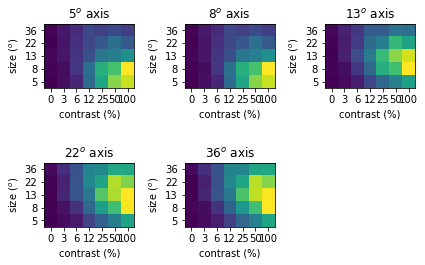

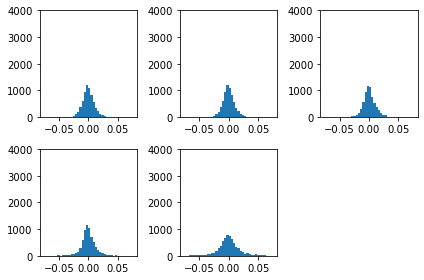

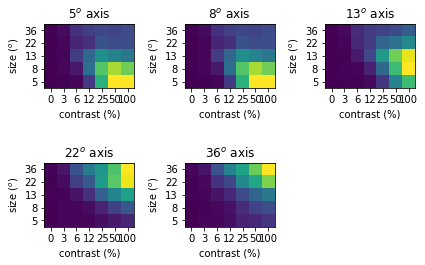

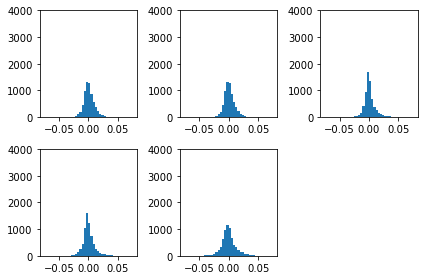

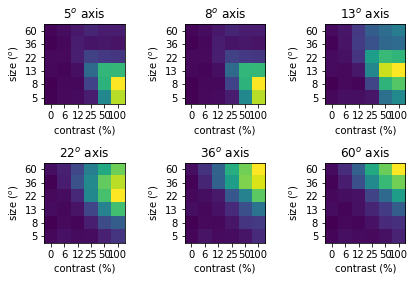

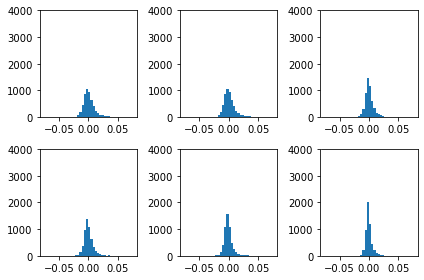

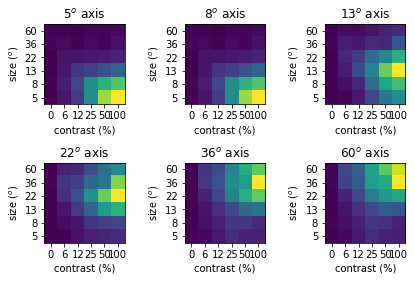

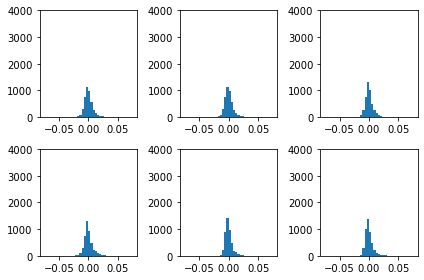

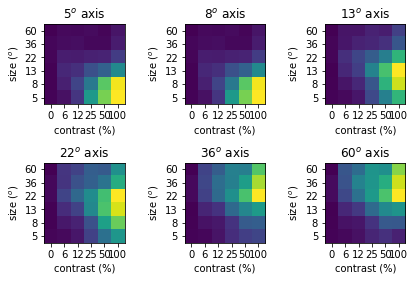

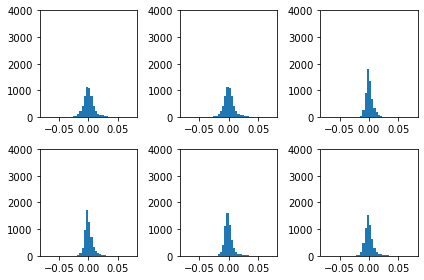

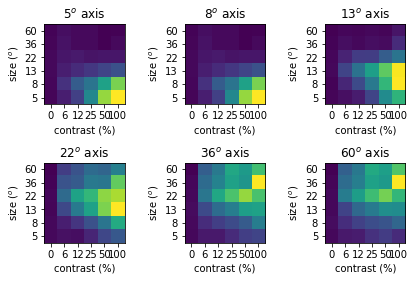

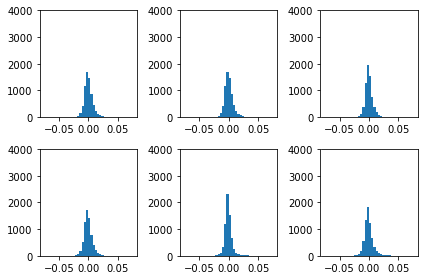

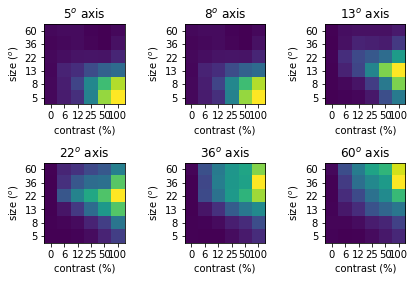

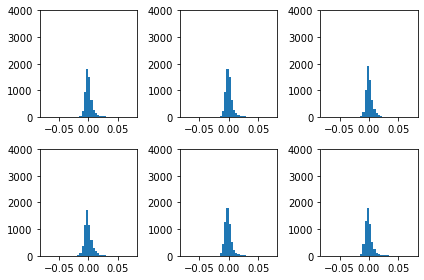

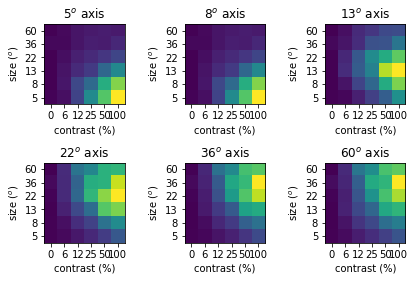

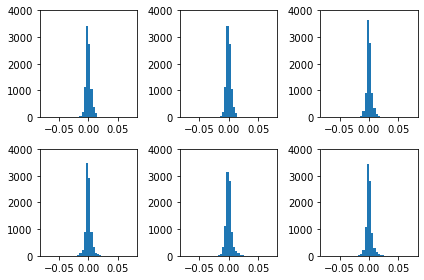

In [34]:
for iexpt in range(len(tuning_tavg)):
    if not tuning_tavg[iexpt] is None and not contrast_axis[irep][iexpt] is None:
        data = np.nanmean(tuning_tavg[iexpt],3)
        if contrast_axis[irep][iexpt] is None:
            print(str((irep,iexpt)) + ' is None')
        else:
            print(iexpt)
            if data.shape[1] == 5:
                usize = np.array((5,8,13,22,36))
            else:
                usize = np.array((5,8,13,22,36,60))
            if data.shape[2] == 6:
                ucontrast = np.array((0,6,12,25,50,100))
            else:
                ucontrast = np.array((0,3,6,12,25,50,100))
            plt.figure()
            for isize in range(contrast_axis[irep][iexpt].shape[0]):
                plt.subplot(2,3,isize+1)
                top = [contrast_axis[irep][iexpt][isize,iangle]>np.percentile(contrast_axis[irep][iexpt][isize,iangle],95) \
                       for iangle in range(contrast_axis[irep][iexpt].shape[1])]
                
                sca.show_size_contrast(np.nanmean(np.concatenate([data[t] for t in top]),0),flipud=True,usize=usize,ucontrast=ucontrast)
                plt.title('%d$^o$ axis'%usize[isize])
            plt.tight_layout()
            if iexpt == 5:
                plt.savefig('figures/example_mean_tuning_by_axis.eps')
#                 print('got here')
            plt.figure()
            for isize in range(contrast_axis[irep][iexpt].shape[0]):
                plt.subplot(2,3,isize+1)
                plt.hist(contrast_axis[irep][iexpt][isize,:].flatten(),bins=np.linspace(-0.075,0.075,41))
                plt.ylim((0,4000))
            plt.tight_layout()

In [36]:
nrep,nexpt = len(contrast_axis),len(contrast_axis[0])
nsize_max = 6
wt_sd = np.nan*np.ones((nrep,nexpt,nsize_max))
for irep in range(nrep):
    for iexpt in range(nexpt):
        if not contrast_axis[irep][iexpt] is None:
            nsize = contrast_axis[irep][iexpt].shape[0]
            for isize in range(nsize):
                wt_sd[irep,iexpt,isize] = contrast_axis[irep][iexpt][isize,:].flatten().std()

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


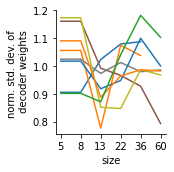

In [37]:
    plt.figure(figsize=(2.5,2.5))
    plt.plot((np.nanmean(wt_sd[:,:,:],0)/np.nanmean(np.nanmean(wt_sd[:,:,:],0),1)[:,np.newaxis]).T)
    plt.xlabel('size')
    plt.xticks(np.arange(6),usize)
    plt.ylabel('norm. std. dev. of \n decoder weights')
    ut.erase_top_right()
    plt.tight_layout()
    plt.savefig('figures/decoder_weight_distribution_vs_size.eps')

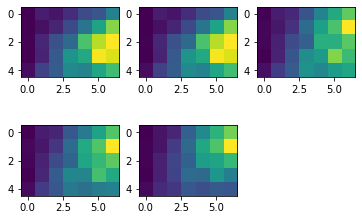

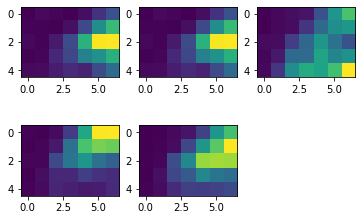

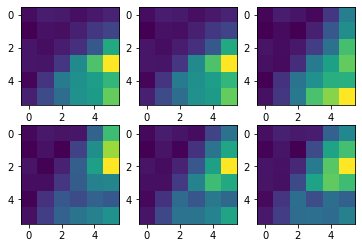

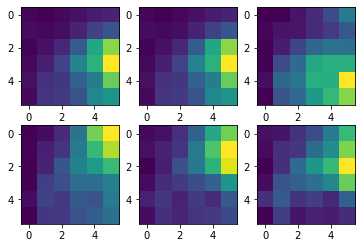

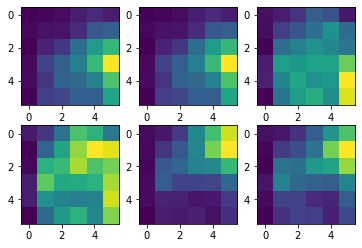

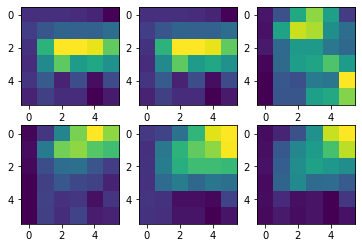

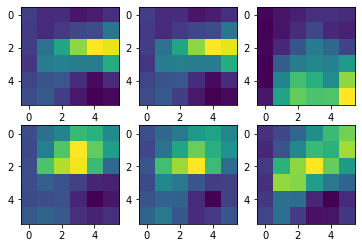

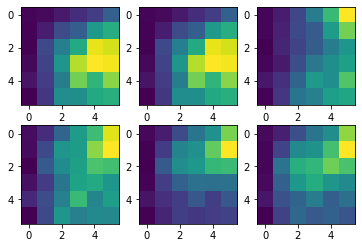

In [40]:
for iexpt in range(len(tuning_tavg)):
    if not tuning_tavg[iexpt] is None and not contrast_axis[irep][iexpt] is None:
        data = np.nanmean(tuning_tavg[iexpt],3)
        plt.figure()
        for isize in range(contrast_axis[irep][iexpt].shape[0]):
            plt.subplot(2,3,isize+1)
            top = [contrast_axis[irep][iexpt][isize,iangle]<np.percentile(contrast_axis[irep][iexpt][isize,iangle],5) \
                   for iangle in range(contrast_axis[irep][iexpt].shape[1])]
            plt.imshow(np.nanmean(np.concatenate([data[t] for t in top]),0))

In [41]:
modal_uparam = [np.array([ 5.        ,  8.21865442, 13.50925609, 22.20558144, 36.5       , 60.        ]),
                np.array([0.  , 0.03, 0.06, 0.12, 0.25, 0.5 , 1.  ])]
usize,ucontrast = modal_uparam

In [42]:
hit_mean = [np.nan*np.ones((len(hit[irep]),modal_uparam[0].size,modal_uparam[1].size)) for irep in range(nreps)]
for irep in range(nreps):
    for iexpt in range(hit_mean[irep].shape[0]):
        if not hit[irep][iexpt] is None:
            this_data = np.nanmean(hit[irep][iexpt],axis=2)
            this_uparam = [proc[irep][iexpt]['usize'],proc[irep][iexpt]['ucontrast']]
            ut.assign_from_uparam(hit_mean[irep][iexpt],modal_uparam,this_data,this_uparam,ignore_first=0)
hit_mean = np.concatenate([h[np.newaxis] for h in hit_mean],axis=0)
hit_mean = np.nanmean(hit_mean,0)

/Users/dan/Documents/code/adesnal/pyute.py:1717: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  big_ind = big_ind*iit[slc]
/Users/dan/Documents/code/adesnal/pyute.py:1708: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a[[slice(None) for iind in range(ignore_first)]+[a_bool]] = b[[slice(None) for iind in range(ignore_first)]+[b_bool]]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


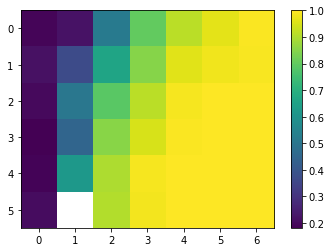

In [43]:
plt.figure()
plt.imshow(np.nanmean(hit_mean,0))
plt.colorbar()

In [44]:
contrast_bdy = 100*np.concatenate(((0,),0.5*(ucontrast[:-1]+ucontrast[1:]),(1.01,)))
size_bdy = np.concatenate(((0,),0.5*(usize[:-1]+usize[1:]),(60,)))
def nansem(arr):
    return np.nanstd(arr)/np.sqrt(arr.size)
def boot_pct(arr,pct):
    return ut.bootstrap(arr,fn=np.nanmean,axis=0,pct=(pct,))[0]
lick_rate_interp = sst.binned_statistic_2d(size,contrast,lick_rate,bins=(size_bdy,contrast_bdy),statistic=np.nanmean).statistic
lick_rate_interp_lb = sst.binned_statistic_2d(size,contrast,lick_rate,bins=(size_bdy,contrast_bdy),statistic=lambda x: boot_pct(x,16)).statistic
lick_rate_interp_ub = sst.binned_statistic_2d(size,contrast,lick_rate,bins=(size_bdy,contrast_bdy),statistic=lambda x: boot_pct(x,84)).statistic

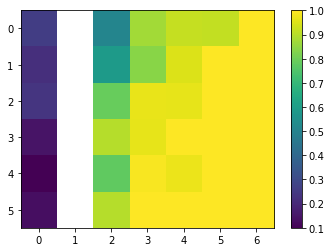

In [45]:
plt.figure()
plt.imshow(hit_mean[iexpt])
plt.colorbar()

In [46]:
reload(nra)
c50s_decoder = np.nan*np.ones(hit_mean.shape[:2])
c50std_decoder = np.nan*np.ones(hit_mean.shape[:2])
for iexpt in range(hit_mean.shape[0]):
    slkat = np.sum(~np.isnan(hit_mean[iexpt]),1)>0
    clkat = np.sum(~np.isnan(hit_mean[iexpt]),0)>0
    if slkat.sum() and clkat.sum():
        x,cov = nra.fit_opt_params_weibull(100*ucontrast[clkat],hit_mean[iexpt][slkat,:][:,clkat])
        c50s_decoder[iexpt][slkat] = x[2*slkat.sum():3*slkat.sum()]
        c50std_decoder[iexpt][slkat] = np.sqrt(np.diag(cov[2*slkat.sum():3*slkat.sum(),2*slkat.sum():3*slkat.sum()]))
    

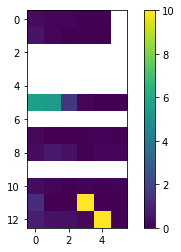

In [47]:
plt.figure()
plt.imshow(c50std_decoder,vmin=0,vmax=10)
plt.colorbar()

In [48]:
size_by_animal = [None for _ in range(int(animal_id.max()+1))]
c50s_animal = [None for _ in range(int(animal_id.max()+1))]
c50std_animal = [None for _ in range(int(animal_id.max()+1))]
for this_id in np.unique(animal_id).astype('int'):
    these_sizes = np.unique(size[animal_id==this_id])
    size_by_animal[this_id] = these_sizes
    c50s_animal[this_id] = np.nan*np.ones((len(these_sizes),))
    c50std_animal[this_id] = np.nan*np.ones((len(these_sizes),))
    for isize,this_size in enumerate(these_sizes):
        lkat = (animal_id==this_id) & (size==this_size)
        these_contrasts = contrast[lkat]
        these_licks = lick_rate[lkat]
        x,cov = nra.fit_opt_params_weibull(these_contrasts,lick_rate[np.newaxis,lkat])
        c50s_animal[this_id][isize] = x[2]
        c50std_animal[this_id][isize] = np.sqrt(cov[2,2])
c50s_animal = np.concatenate(c50s_animal)
c50std_animal = np.concatenate(c50std_animal)
size_by_animal = np.concatenate(size_by_animal)

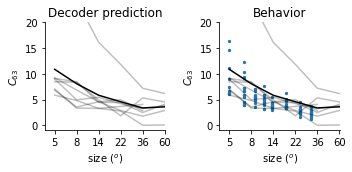

In [49]:
plt.figure(figsize=(5,2.5))
plt.subplot(1,2,1)
plt.plot(np.log10(usize),c50s_decoder.T,c='k',alpha=0.25)
# for iexpt in range(c50s.shape[0]):
#     plt.errorbar(np.log10(usize),c50s[iexpt],yerr=c50std[iexpt],c='k',alpha=0.25)
plt.plot(np.log10(usize),np.nanmean(c50s_decoder,0),c='k')
# plt.yticks((-1,0,1),(0.1,1,10))
# plt.scatter(np.log10(usize).flatten(),np.log10(c50s.T).flatten(),c='k',alpha=0.25)
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
plt.ylim((-1,20))
plt.xlim((np.log10(4),np.log10(61)))
ut.erase_top_right()
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
plt.title('Decoder prediction')
plt.subplot(1,2,2)
plt.scatter(np.log10(size_by_animal),c50s_animal,s=5)
plt.plot(np.log10(usize),c50s_decoder.T,c='k',alpha=0.25)
plt.plot(np.log10(usize),np.nanmean(c50s_decoder,0),c='k')#,linestyle='dashed')
ut.erase_top_right()
plt.ylim((-1,20))
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
plt.xlim((np.log10(4),np.log10(61)))
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
plt.title('Behavior')
plt.tight_layout()
# plt.savefig('figures/weibull_lambda_decoder_and_behavior.jpg',dpi=300)

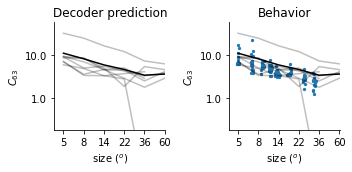

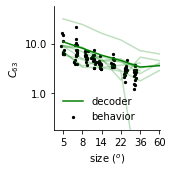

In [50]:
plt.figure(figsize=(5,2.5))
plt.subplot(1,2,1)
plt.plot(np.log10(usize),np.log10(c50s_decoder).T,c='k',alpha=0.25)
# for iexpt in range(c50s.shape[0]):
#     plt.errorbar(np.log10(usize),c50s[iexpt],yerr=c50std[iexpt],c='k',alpha=0.25)
plt.plot(np.log10(usize),np.log10(np.nanmean(c50s_decoder,0)),c='k')
# plt.yticks((-1,0,1),(0.1,1,10))
# plt.scatter(np.log10(usize).flatten(),np.log10(c50s.T).flatten(),c='k',alpha=0.25)
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
yticks = np.arange(-1,2).astype('float')
ytick_lbls = [10**yt for yt in yticks]
plt.yticks(yticks,ytick_lbls)
plt.ylim((-0.75,1.75))
plt.xlim((np.log10(4),np.log10(61)))
ut.erase_top_right()
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
plt.title('Decoder prediction')

plt.subplot(1,2,2)
plt.scatter(np.log10(size_by_animal)+0.01*np.random.randn(*(size_by_animal.shape)),np.log10(c50s_animal),s=5)
plt.plot(np.log10(usize),np.log10(c50s_decoder).T,c='k',alpha=0.25)
plt.plot(np.log10(usize),np.log10(np.nanmean(c50s_decoder,0)),c='k')
# plt.plot(np.log10(usize),np.nanmean(c50s,0),c='k')#,linestyle='dashed')
ut.erase_top_right()
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
yticks = np.arange(-1,2).astype('float')
ytick_lbls = [10**yt for yt in yticks]
plt.yticks(yticks,ytick_lbls)
plt.xlim((np.log10(4),np.log10(61)))
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
plt.title('Behavior')
plt.ylim((-0.75,1.75))
plt.tight_layout()
# plt.savefig('figures/weibull_lambda_decoder_and_behavior.jpg',dpi=300)

plt.figure(figsize=(2.5,2.5))
plt.scatter(np.log10(size_by_animal)+0.01*np.random.randn(*(size_by_animal.shape)),np.log10(c50s_animal),s=5,c='k',label='behavior')
plt.plot(np.log10(usize),np.log10(c50s_decoder).T,c=np.array((0,0.5,0)),alpha=0.25)
plt.plot(np.log10(usize),np.log10(np.nanmean(c50s_decoder,0)),c=np.array((0,0.5,0)),label='decoder')
# plt.plot(np.log10(usize),np.nanmean(c50s,0),c='k')#,linestyle='dashed')
ut.erase_top_right()
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
yticks = np.arange(-1,2).astype('float')
ytick_lbls = [10**yt for yt in yticks]
plt.yticks(yticks,ytick_lbls)
plt.xlim((np.log10(4),np.log10(61)))
plt.legend(frameon=False)
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
# plt.title('Behavior')
plt.ylim((-0.75,1.75))
plt.tight_layout()
# plt.savefig('figures/weibull_lambda_decoder_and_behavior_one_plot.jpg',dpi=300)

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


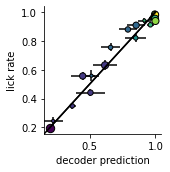

In [52]:
reload(sca)
plt.figure(figsize=(2.5,2.5))
sca.scatter_size_contrast_errorbar(hit_mean,np.concatenate((lick_rate_interp_lb[np.newaxis],lick_rate_interp_ub[np.newaxis])),equate_0=True,nsize=6,ncontrast=7)
plt.plot((0,1),(0,1),c='k')
ut.erase_top_right()
plt.xlabel('decoder prediction')
plt.ylabel('lick rate')
plt.tight_layout()
# plt.savefig('figures/lick_rate_vs_decoder_size_contrast.eps')

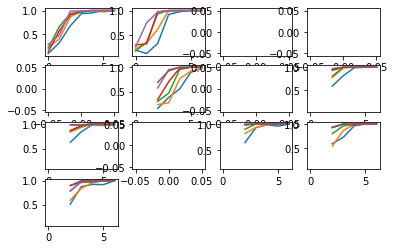

In [53]:
plt.figure()
for iexpt in range(hit_mean.shape[0]):
    plt.subplot(4,4,iexpt+1)
    plt.plot(hit_mean[iexpt].T)

/Users/dan/Documents/code/adesnal/pyute.py:947: RuntimeWarning: Mean of empty slice
  mn_tgt = np.nanmean(arr,0)
/Users/dan/Documents/code/adesnal/pyute.py:141: RuntimeWarning: Mean of empty slice
  stat = fn(resamp,axis=axis)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


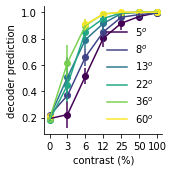

In [54]:
plt.figure(figsize=(2.5,2.5))
ut.plot_bootstrapped_errorbars_hillel(np.arange(7),hit_mean,pct=(16,84))
plt.xticks(np.arange(7),(100*ucontrast).astype('int'))
plt.legend([r'%d$^o$'%i for i in usize.astype('int')],frameon=False)
plt.ylabel('decoder prediction')
plt.xlabel('contrast (%)')
ut.erase_top_right()
plt.tight_layout()
# plt.savefig('figures/decoder_performance_size_contrast.eps')

In [62]:
irep = 0
usize,ucontrast = proc[irep][-1]['usize'],proc[irep][-1]['ucontrast']
modal_uparam = [usize,ucontrast]
nsize,ncontrast = len(usize),len(ucontrast)

In [63]:
def show_auroc(auroc,label='Population decoder detection AUROC'):
    sca.show_size_contrast(auroc[:,1:],flipud=True,usize=usize,ucontrast=100*ucontrast[1:])
    plt.colorbar().set_label(label)
    plt.clim([0.5,1])

/Users/dan/Documents/code/adesnal/pyute.py:1717: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  big_ind = big_ind*iit[slc]
/Users/dan/Documents/code/adesnal/pyute.py:1708: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a[[slice(None) for iind in range(ignore_first)]+[a_bool]] = b[[slice(None) for iind in range(ignore_first)]+[b_bool]]


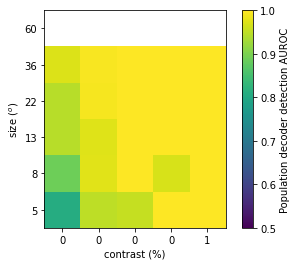

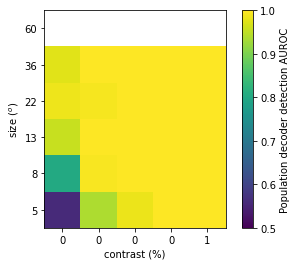

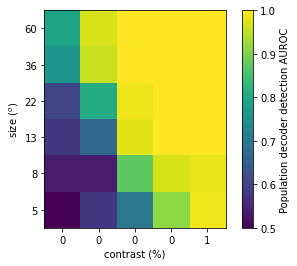

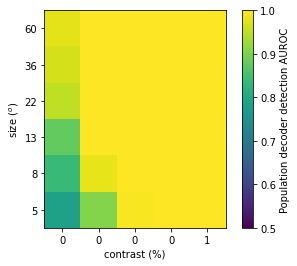

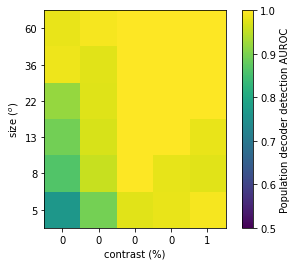

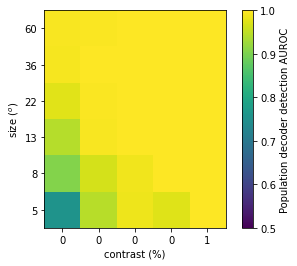

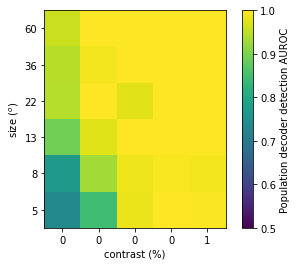

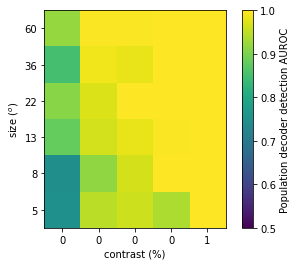

In [66]:
reload(ut)
reload(sca)
nexpt = len(proc[irep])
# auroc_mean = [None for iexpt in range(nexpt)]
auroc_mean = np.nan*np.ones((nexpt,nsize,ncontrast))
for iexpt in range(len(proc[irep])):
    if not auroc[irep][iexpt] is None:
        plt.figure()
        this_data = np.nanmean(np.nanmean(np.concatenate([a[iexpt][np.newaxis] for a in auroc],axis=0),axis=0),-1)
        this_uparam = [proc[irep][iexpt]['usize'],proc[irep][iexpt]['ucontrast']]
        ut.assign_from_uparam(auroc_mean[iexpt],modal_uparam,this_data,this_uparam,ignore_first=0)
        sca.show_auroc(auroc_mean[iexpt],usize=usize,ucontrast=ucontrast)
#         sca.show_size_contrast(auroc_mean[iexpt][:,1:],flipud=True,usize=proc[iexpt]['usize'],ucontrast=100*proc[iexpt]['ucontrast'][1:])
#         plt.colorbar().set_label('Population decoder AUROC')
#         plt.clim([0.5,1])
        

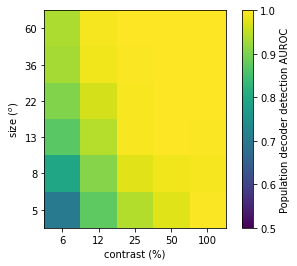

In [67]:
plt.figure()
ut.mkdir('figures')
show_auroc(np.nanmean(auroc_mean,0))
np.save('../shared_data/pyr_l23_population_detection_by_size_and_contrast_auroc.npy',auroc_mean)
plt.savefig('figures/pyr_l23_population_detection_by_size_and_contrast.jpg',dpi=300)